# Delimiter Analysis

In [1]:
import sys

sys.path.append("../src")
import train

In [2]:
import torch

RUN = "../runs/nlab-gpt-medium-8.7M-eb4543e4/nlab-gpt-medium-8.7M-eb4543e4-2025-12-16-46500-[best(2.0324)].pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run = train.Run.from_file(RUN)
run.model.to(device)
None  # No output

In [3]:
val_data = torch.load("../data/val_data.pt").to(device)

In [4]:
import collections


class UnbalancedDelimiter(Exception): ...


# Compute the token positions of every balanced delimiters '(' and ')'
# LIMITATION: Weird tokens like "((", "))", ")(" are naively handled.
# def get_delimiters(input_ids, allow_unmatched_opened=True):
#     tokens = [run.tokenizer.decode([i]) for i in input_ids]
#     opened = []
#     pairs = []
#     for n, token in enumerate(tokens):
#         for char in token:
#             match char:
#                 case "(":
#                     opened.append((n, token))
#                 case ")":
#                     if not opened:
#                         raise UnbalancedDelimiter("Found ')' with empty stack")
#                     i, otoken = opened.pop()
#                     # We only push pairs of distinguishable tokens
#                     co, cc = collections.Counter(otoken), collections.Counter(token)
#                     if not any(
#                         t.count("(") + t.count(")") > 1 for t in [otoken, token]
#                     ):
#                         pairs.append((i, n))
#     if not allow_unmatched_opened and opened:
#         raise UnbalancedDelimiter(f"Unmatched '(' remaining: {len(opened)}")
#     return pairs
def get_delimiters(input_ids, allow_unmatched_opened=True):
    tokens = [run.tokenizer.decode([i]) for i in input_ids]
    opened = []
    pairs = []
    active = False
    for n, token in enumerate(tokens):
        if token.endswith("\\"):
            active = True
            continue
        if active:
            match token:
                case "begin":
                    opened.append(n)
                case "end":
                    if not opened:
                        raise UnbalancedDelimiter("Found '\\end' with empty stack")
                    o = opened.pop()
                    pairs.append((o, n))
            active = False
    if not allow_unmatched_opened and opened:
        raise UnbalancedDelimiter(f"Unmatched '\\begin' remaining: {len(opened)}")
    return pairs


# Generate a batch of sequences with balanced delimiters
# The sequences are not guaranteed to be distinct (or to not overlap)
def get_batch(
    run,
    oversample_factor=8,
    max_rounds=200,
    min_pairs=1,
    allow_unmatched_opened=True,
):
    N = val_data.size(0)
    B = run.config.per_device_train_batch_size
    T = run.config.max_position_embeddings

    ar = torch.arange(T, device=device)[None, :]  # (1, T)

    xs = []
    xpairs = []

    # for _ in range(max_rounds):
    while True:
        K = oversample_factor * (B - len(xs))
        if K <= 0:
            break

        start = torch.randint(0, N - T - 1, (K,), device=device)
        pos = start[:, None] + ar  # (K, T)

        xk = val_data[pos].to(device)  # (K, T)

        for i in range(K):
            x = xk[i]
            try:
                pairs = get_delimiters(
                    x,
                    allow_unmatched_opened=allow_unmatched_opened,
                )
            except UnbalancedDelimiter:
                continue
            if len(pairs) < min_pairs:
                continue

            xs.append(x)
            xpairs.append(pairs)

            if len(xs) == B:
                break

        if len(xs) == B:
            break

    if len(xs) < B:
        raise RuntimeError(
            f"Could not fill batch: got {len(xs)}/{B} balanced windows after "
            f"{max_rounds} rounds. Try lowering T, lowering min_pairs, or increasing oversample_factor."
        )

    return torch.stack(xs, dim=0), xpairs

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm


def get_cms_hits(run, max_iters=20, top_k=10, no_bar=False):
    score = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.float64
    )
    count = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.int64
    )

    hit = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.int64
    )
    total = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.int64
    )

    for _ in tqdm.notebook.tqdm(
        range(max_iters),
        desc="Computing CMS + %Hit",
        unit="passes",
        disable=no_bar,
    ):
        input_ids, pairs = get_batch(run, min_pairs=1, max_rounds=1000)

        opens = [sorted({o for o, c in l}) for l in pairs]

        def attention_callback(layer, head, attn_weight):
            B, T, _ = attn_weight.shape

            for b in range(B):
                for o, c in pairs[b]:
                    top = np.argsort(attn_weight[b, c, : c + 1])[-top_k:]
                    hit[layer][head] += int(o in top)

                    cand = [o2 for o2 in opens[b] if o2 < c and o2 != o]
                    # if not cand:
                    #     continue
                    s = float("-inf")
                    for shift_c, shift_o in [(0, 0), (0, 1), (1, 0), (1, 1)]:
                        deviation = 0.0
                        if cand:
                            deviation = sum(
                                max(
                                    attn_weight[b][c - x][o2 - y]
                                    for x, y in [(0, 0), (0, 1), (1, 0), (1, 1)]
                                )
                                for o2 in cand
                            ) / len(cand)
                        x = attn_weight[b][c - shift_c][o - shift_o] - deviation
                        if x > s:
                            s = x
                    score[layer][head] += s
                    count[layer][head] += 1
            total[layer][head] += B * sum(len(p) for p in pairs)

        with torch.no_grad():
            run.model(input_ids, attention_callback=attention_callback)

    outs = np.zeros_like(score)
    mask = count > 0
    outs[mask] = score[mask] / count[mask]

    outh = np.zeros_like(hit, dtype=np.float64)
    mask = total > 0
    outh[mask] = hit[mask] / total[mask]
    # ((L, H), (L, H))
    return outs, outh


def show_cms_hits(run, score, hit, top_k=10):

    fig, axes = plt.subplots(ncols=2)

    ax = axes[0]

    ax.set_xticks(range(run.config.num_attention_heads))
    ax.set_xticklabels(
        [f"Head {h}" for h in range(run.config.num_attention_heads)],
        fontsize=6,
        rotation=90,
    )

    ax.set_yticks(range(run.config.num_hidden_layers))
    ax.set_yticklabels(
        [f"Layer {l}" for l in range(run.config.num_hidden_layers)], fontsize=6
    )

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.imshow(
        score,
        cmap="viridis",
        aspect="equal",
        interpolation="nearest",
        origin="upper",
    )

    ax.set_title(f"CMS")

    ax = axes[1]

    ax.set_xticks(range(run.config.num_attention_heads))
    ax.set_xticklabels(
        [f"Head {h}" for h in range(run.config.num_attention_heads)],
        fontsize=6,
        rotation=90,
    )

    ax.set_yticks(range(run.config.num_hidden_layers))
    ax.set_yticklabels(
        [f"Layer {l}" for l in range(run.config.num_hidden_layers)], fontsize=6
    )

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.imshow(
        hit,
        cmap="viridis",
        aspect="equal",
        interpolation="nearest",
        origin="upper",
    )

    ax.set_title(f"%Hit (Top {top_k})")

    l, h = np.unravel_index(score.argmax(), score.shape)
    fig.text(
        0,
        -0.05,
        f"Best head: (Layer {l}, Head {h}) | CMS = {score[l][h]:.4f}, %Hit = {hit[l][h]:.2%}",
    )

    plt.suptitle(
        f"Contrastive Matching Score for '(', ')' + %Hit (Top {top_k}): {run.name[:-9]}"
    )
    plt.tight_layout()
    plt.savefig(f"../assets/cms-{run.name[:-9]}.png", dpi=300, bbox_inches="tight")
    plt.show()

Computing CMS + %Hit:   0%|          | 0/3000 [00:00<?, ?passes/s]

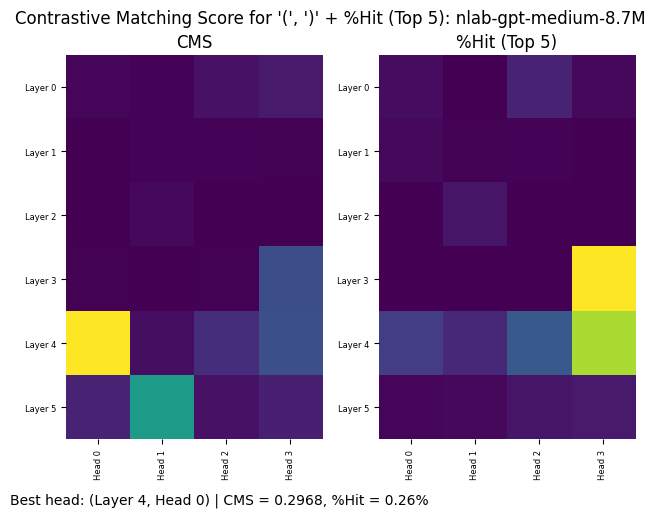

In [6]:
show_cms_hits(run, *get_cms_hits(run, max_iters=3000, top_k=5), top_k=5)

In [7]:
import pathlib

import matplotlib.colors as mcolors
import tqdm

CHECKPOINTS = "../runs/nlab-gpt-medium-8.7M-eb4543e4"

steps = []
max_cms_global = [[] for _ in range(run.config.num_hidden_layers)]
gap_cms_global = [[] for _ in range(run.config.num_hidden_layers)]

for path in tqdm.notebook.tqdm(
    list(pathlib.Path(CHECKPOINTS).rglob("*.pt")), desc="Processing", unit="checkpoints"
):
    path = str(path)
    # Skip the final checkpoint
    if path.endswith("-[final].pt"):
        continue
    run = train.Run.from_file(path)

    steps.append(run.global_step)
    # ((L, H), (L, H))
    cms, hit = get_cms_hits(run, max_iters=50, top_k=5, no_bar=True)

    max_cms = cms.max(axis=1)
    gap_cms = max_cms - np.median(cms, axis=1)

    for l in range(run.config.num_hidden_layers):
        max_cms_global[l].append(max_cms[l])
        gap_cms_global[l].append(gap_cms[l])

Processing:   0%|          | 0/56 [00:00<?, ?checkpoints/s]

In [8]:
values = np.linspace(0, 5, run.config.num_hidden_layers)
norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())
cmap = plt.cm.viridis

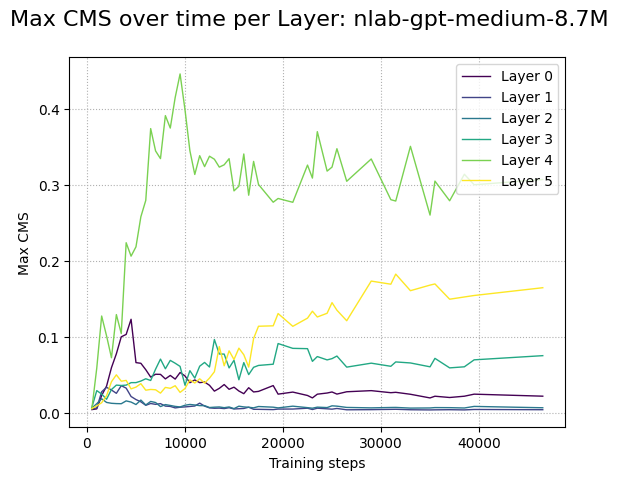

In [9]:
for l in range(run.config.num_hidden_layers):
    plt.plot(
        steps,
        max_cms_global[l],
        label=f"Layer {l}",
        linewidth=1.0,
        color=cmap(norm(values[l])),
    )

plt.xlabel("Training steps")
plt.ylabel("Max CMS")

plt.suptitle(f"Max CMS over time per Layer: {run.name[:-9]}", fontsize=16)
plt.legend()
plt.grid(which="both", linestyle="dotted")

plt.savefig(f"../assets/max-cms-{run.name[:-9]}.png", dpi=300, bbox_inches="tight")
plt.show()

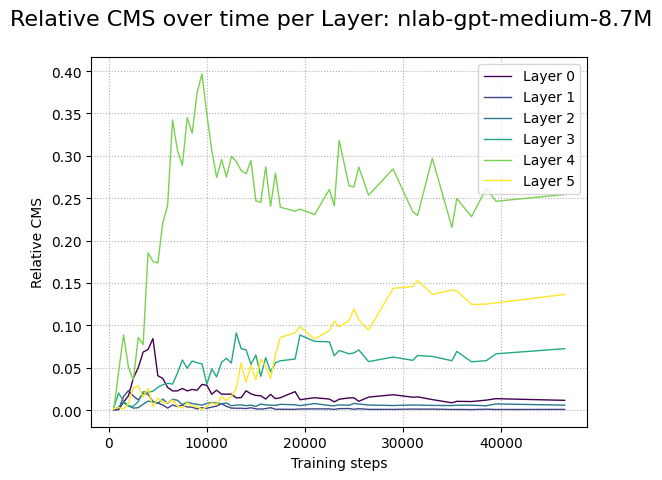

In [10]:
for l, v in enumerate(values):
    plt.plot(
        steps, gap_cms_global[l], label=f"Layer {l}", linewidth=1.0, color=cmap(norm(v))
    )

plt.xlabel("Training steps")
plt.ylabel("Relative CMS")

plt.suptitle(f"Relative CMS over time per Layer: {run.name[:-9]}", fontsize=16)
plt.legend()
plt.grid(which="both", linestyle="dotted")

plt.savefig(f"../assets/relative-cms-{run.name[:-9]}.png", dpi=300, bbox_inches="tight")
plt.show()